# Mongo DB con Python

##### Inicialización de la base de datos

Para importart los datos a nuestra base de datos MongoDB, vamos a crear un pequeño programa en python para importar desde el fichero _incidentes.csv_ que hemos visto en la entrega anterior.



In [2]:
#!/usr/bin/env python
import os
from pymongo import MongoClient
import pandas as pd
import json
import progressbar

STEP = 200

client = MongoClient()
db = client['datascience']
incid = db.incidents
incid.delete_many({})
csv = pd.read_csv('/home/guillermo/data-science/cpp_db/incidents.csv', sep=';')

bar = progressbar.ProgressBar()
for start in bar(range(0, len(csv.index), STEP)):
    partial_csv = csv.loc[start:(start + STEP), :]
    csv_to_json = json.loads(partial_csv.to_json(orient='records'))
    incid.insert_many(csv_to_json)
    del partial_csv
    del csv_to_json


100% |########################################################################|


Con esto, ya podemos hacer operaciones con los datos. En esta entrega nos centraremos en las consultas que podemos ver en el archivo README.md del proyecto.

#### Preparar las consultas

Para empezar a hacer consultas en PyMongo, primero tenemos que importar los paquetes necesarios, inicializar las variables de gráficas y conectar la base de datos a python:


In [23]:
import pandas as pd
import sys
sys.path.insert(0,'..')
import pymongo
from pymongo import MongoClient
import matplotlib.pyplot as plt

print('Mongo version', pymongo.__version__)
client = MongoClient('localhost', 27017)
db = client.datascience
collection = db.incidents

Mongo version 3.6.1


Con esto, ya estamos conectados y listos para hacer consultas.

####  Distritos con mayor número de incidencias

Para esta consulta, lo que tenemos que conseguir son las incidencias agrupadas por distritos.

In [3]:
incid_by_district = [
    {"$group": {"_id": "$PdDistrict", "count": {"$sum": 1}}}
]
aggResult = collection.aggregate(incid_by_district, allowDiskUse= True)
dist_count = pd.DataFrame(list(aggResult))
print("Distritos encontrados: ", dist_count["_id"].size)
dist_count

Distritos encontrados:  11


,_id,count
0,RICHMOND,115715
1,TARAVAL,165447
2,NORTHERN,270115
3,0,1
4,PARK,124399
5,CENTRAL,223355
6,INGLESIDE,192696
7,MISSION,297224
8,BAYVIEW,219482
9,TENDERLOIN,190832


En este caso vemos que hay una fila cuyo nombre es "0". Esto puede deberse a que el campo aparece como nulo o ha habido un error en la importación de los datos. Ahora mostraremos los distritos en una gráfica para poder analizarlos mejor.


Incidentes por distrito


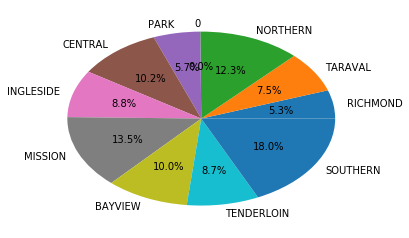

In [7]:
labels = dist_count['_id']
incidents = dist_count['count']

plt.pie(incidents, labels=labels, autopct='%1.1f%%')
print('Incidentes por distrito')

####  Día de la semana con mayor número de incidentes

En este caso, agruparemos los incidentes por día de la semana y los ordenaremos de mayor a menor. Los tres primeros serán aquellos en los que mas incidentes se produzcan.

In [12]:
day_incidences = [
    {"$group": {"_id": "$DayOfWeek", "count": {"$sum": 1}}},
    {"$sort": { "count": -1 }}
]
aggResult2 = collection.aggregate(day_incidences, allowDiskUse= True)
day_incid = pd.DataFrame(list(aggResult2))
print("Días de la semana: ", day_incid["_id"].size)
day_incid.head(3)

Días de la semana:  7


,_id,count
0,Friday,334790
1,Wednesday,321096
2,Saturday,317543


Con esto concluimos que los días que más incidencias registran son los viernes, miércoles y sábados.

#### Incidencias que impliquen la acción de un perro

Estos incidentes tienen en común que aparece la palabra _DOG_ en su campo descripción. Para consultarlos, haremos uso de las expresiones regulares de MongoDB

In [9]:
incid_dogs = [
  {"$match": {"Descript": {"$regex": ".*DOG.*"}}}
]
aggResult3 = collection.aggregate(incid_dogs)
dog_no_res = pd.DataFrame(list(aggResult3))
print("Incidentes causados por perros: ", dog_no_res["_id"].size)
dog_no_res.head(7)

Incidentes causados por perros:  3691


,Address,Category,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,PdId,Resolution,Time,X,Y,_id
0,1000 Block of FOLSOM ST,NON-CRIMINAL,2015-02-01,Sunday,"AIDED CASE, DOG BITE",150098630,"(37.778254811523, -122.405834032593)",SOUTHERN,15009863064010,NONE,18:38:00,-122.405834,37.778255,5adf345f183a4f700046816a
1,700 Block of STANYAN ST,NON-CRIMINAL,2015-02-06,Friday,"AIDED CASE, DOG BITE",150113539,"(37.7687142722405, -122.453376250788)",PARK,15011353964010,NONE,08:25:00,-122.453376,37.768714,5adf345f183a4f700046881e
2,300 Block of EDINBURGH ST,NON-CRIMINAL,2015-01-28,Wednesday,"AIDED CASE, DOG BITE",150122295,"(37.7235205085999, -122.430194700261)",INGLESIDE,15012229564010,NONE,18:30:00,-122.430195,37.723521,5adf345f183a4f7000468bf0
3,100 Block of TARAVAL ST,NON-CRIMINAL,2015-02-09,Monday,"AIDED CASE, DOG BITE",150123817,"(37.743577781095, -122.466458192036)",TARAVAL,15012381764010,NONE,20:20:00,-122.466458,37.743578,5adf345f183a4f7000468ca9
4,0 Block of BROADWAY ST,NON-CRIMINAL,2015-02-12,Thursday,"AIDED CASE, DOG BITE",150132153,"(37.798931272055, -122.398114598896)",CENTRAL,15013215364010,NONE,13:30:00,-122.398115,37.798931,5adf345f183a4f7000469064
5,1300 Block of 28TH AV,NON-CRIMINAL,2015-02-15,Sunday,"AIDED CASE, DOG BITE",150141154,"(37.7621853429495, -122.486772988151)",TARAVAL,15014115464010,"ARREST, BOOKED",16:45:00,-122.486773,37.762185,5adf345f183a4f700046944a
6,BOWLINGGREEN DR / MARTIN LUTHER KING JR DR,NON-CRIMINAL,2015-02-16,Monday,"AIDED CASE, DOG BITE",150143984,"(37.7674489968121, -122.460676556023)",PARK,15014398464010,NONE,15:45:00,-122.460677,37.767449,5adf345f183a4f7000469592


#### Las 5 categorías más frecuentes.

Al igual que en el caso de los días, agrupamos los incidentes por categoría y ordenamos de mayor a menor

In [11]:
common_categories = [
    {"$group": {"_id": "$Category", "count": {"$sum": 1}}},
    {"$sort": { "count": -1 }}
]
aggResult4 = collection.aggregate(common_categories)
comm_categ = pd.DataFrame(list(aggResult4))
print("Contador: ", comm_categ["_id"].size)
comm_categ.head(5)

Contador:  39


,_id,count
0,LARCENY/THEFT,473931
1,OTHER OFFENSES,307251
2,NON-CRIMINAL,235977
3,ASSAULT,192645
4,VEHICLE THEFT,126273


#### Incidentes sin resolución

Para ello, se necesita buscar aquellas incidencias que tengan un campo _Resolution_ con valor _NONE_.

In [24]:
no_resolution = [
  {"$match": {"Resolution": "NONE"}}
]
aggResult5 = collection.aggregate(no_resolution)
no_res = pd.DataFrame(list(aggResult5))
print("Incidentes sin resolver: ", no_res["_id"].size)

Incidentes sin resolver:  1373312


Como es un número muy alto y no ofrece mucha información, vamos a mostrarlo en forma de gráfico de barras:

Incidentes sin resolución


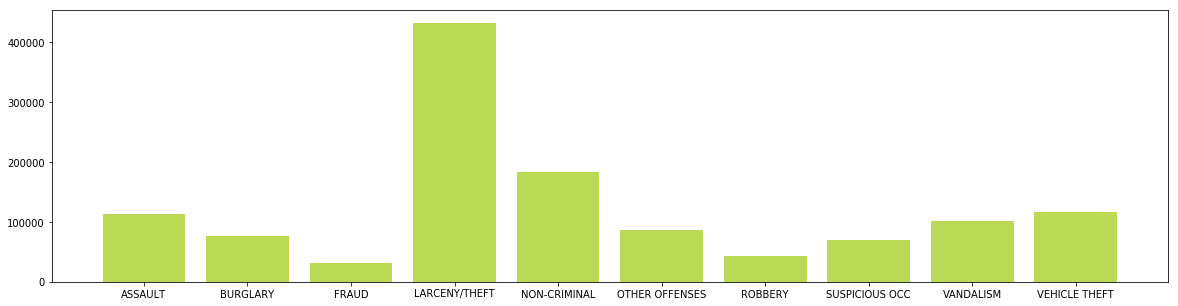

In [29]:
categories = no_res['Category'].value_counts()
plt.figure(figsize=(20,5))

y = []
for num_incid in categories.values:
    y.append(categoria_valor)

x = []
for category_name in categories.index:
    x.append(category_name)
    
plt.bar(eje_x, eje_y, align="center", color="#bada55")
print('Incidentes sin resolución')

Ahora, más gráfico el resultado, podemos ver que la mayor parte de incidentes sin resolución son robos y hurtos, seguido de lejos por incidentes no criminales.